# Mini-projet n°1 - Chats ou Chiens ?

Dans ce projet, nous allons étudier, classifier et segmenter les images du jeu de données Oxford-IIIT Pet Dataset. Ce jeu de données comporte des images de chats et chiens de 37 races différentes.

In [1]:
# Utils
import os
#import shutil
import time
import tensorflow as tf
import re

2025-12-03 10:37:21.300069: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 10:37:21.348553: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 10:37:41.601157: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Maths - Stats
import numpy as np
import pandas as pd
import random as rd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_ind, mannwhitneyu,shapiro

In [3]:
# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns
from PIL import Image 

In [4]:
# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121

## Chargement des données

In [6]:
list = "./annotations//list.txt"
image_dir = "./images"

# Chargement des images du dataset
images = [f for f in os.listdir(image_dir) if f.lower().endswith("jpg")]
print("Il y a ", len(images), "images dans le dataset.")

# Chargement des informations (label) des images, avec le fichier list.txt
df = pd.read_csv(
    list,
    sep=r'\s+',          
    comment='#',         
    header=None,         
    usecols=[0, 1, 2], 
    names=['image', # nom de l'image (sans extension)
           'class_id', # identifiant de la classe (race), entre 1 et 37
           'type'] # type d'animal : 1=chat, 2=chien
)
df["image"] = df["image"].apply(lambda x: x + ".jpg")
n_total = len(df)
print(f"Il y a {n_total} images référencées dans list.txt.")

# Vérification du référencement des images
missing_list = sorted(set(images) - set(df["image"])) # images dans le dataset sans entrée dans list.txt
missing_images = sorted(set(df["image"]) - set(images)) # images référencées dans list.txt mais manquantes dans le dataset
print(f"Il y a {len(missing_list)} images dans le dataset sans entrée dans list.txt.")
print(f"Il y a {len(missing_images)} images référencées dans list.txt mais manquantes dans le dataset.")  

pd.set_option('display.max_rows', None)    # affiche toutes les lignes
pd.set_option('display.max_columns', None) # affiche toutes les colonnes
pd.set_option('display.width', None)       # pas de coupure de lignes
pd.set_option('display.max_colwidth', None) # montre le texte entier dans chaque cellule

Il y a  7390 images dans le dataset.
Il y a 7349 images référencées dans list.txt.
Il y a 41 images dans le dataset sans entrée dans list.txt.
Il y a 0 images référencées dans list.txt mais manquantes dans le dataset.


Certaines images existent dans le dossier "images", mais n'ont pas d'entrées dans list.txt. On va donc les faire rentrer dans le jeu de données, en mettant comme identifiant de classe et type la même chose que les autres fichiers commençant par le même nom.

In [7]:
def get_prefix(filename) :
    name = filename.split('.')[0]
    return re.sub(r'_\d+$', '', name)

# Ajout d'informations dans le DataFrame
df["class"] = df["image"].apply(get_prefix)
df["animal"] = df["type"].apply(lambda x: "cat" if x == 1 else "dog")

# Création d'un dictionnaire de classes connues
classes = (
    df.groupby("class")[["class_id", "type"]]
      .first()
      .to_dict(orient="index")
)

# Ajout du référencement des images dans le DataFrame
new_rows = []
for img in missing_list :
    class_name = get_prefix(img)
    if class_name in classes: # Si on ne connait pas, on ne rajoute pas au DataFrame
        class_id = classes[class_name]["class_id"]
        type = classes[class_name]["type"]
        new_rows.append({
            "image": os.path.splitext(img)[0],
            "class_id": class_id,
            "type": type,
            "class": class_name,
            "animal": "cat" if type == 1 else "dog"
        })

print(f"{len(new_rows)} nouvelles lignes créées.")
df_new = pd.DataFrame(new_rows)
df_full = pd.concat([df, df_new], ignore_index=True)
df_full["image"] = df_full["image"].apply(
    lambda x: x + ".jpg" if not x.lower().endswith(".jpg") else x
)

missing_images = sorted(set(images) - set(df_full["image"]))
print(f"Il y a maintenant {len(missing_images)} images du dataset qui ne sont pas référencées dans le DataFrame.")


df_full.head()

41 nouvelles lignes créées.
Il y a maintenant 0 images du dataset qui ne sont pas référencées dans le DataFrame.


,image,class_id,type,class,animal
0,Abyssinian_100.jpg,1,1,Abyssinian,cat
1,Abyssinian_101.jpg,1,1,Abyssinian,cat
2,Abyssinian_102.jpg,1,1,Abyssinian,cat
3,Abyssinian_103.jpg,1,1,Abyssinian,cat
4,Abyssinian_104.jpg,1,1,Abyssinian,cat


In [8]:
# Nettoyage 
del(df)
df = df_full
del(new_rows)
del(df_new)
del(df_full)

## Analyse exploratoire

### Etude de la répartition par race et par type

In [9]:
df["class"] = df["class"].astype("str")
df["animal"] = df["animal"].astype("str")
df.dtypes

image       object
class_id     int64
type         int64
class       object
animal      object
dtype: object

In [10]:
nb_images = len(df)
n_class = df["class"].nunique()
n_class_cat = df[df["animal"] == "cat"]["class"].nunique()
n_class_dog = df[df["animal"] == "dog"]["class"].nunique()
nb_cat = len(df[df["animal"] == "cat"])
nb_dog = len(df[df["animal"] == "dog"])

print(f"Il y a {n_class} races différentes dans le dataset, pour {nb_images} images.")
print(f"Il y a {n_class_cat} races de chats et {n_class_dog} races de chiens.")
print(f"Cela représente {nb_cat} images de chats et {nb_dog} images de chiens.")


Il y a 37 races différentes dans le dataset, pour 7390 images.
Il y a 12 races de chats et 25 races de chiens.
Cela représente 2400 images de chats et 4990 images de chiens.


/tmp/ipykernel_6330/158086272.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])


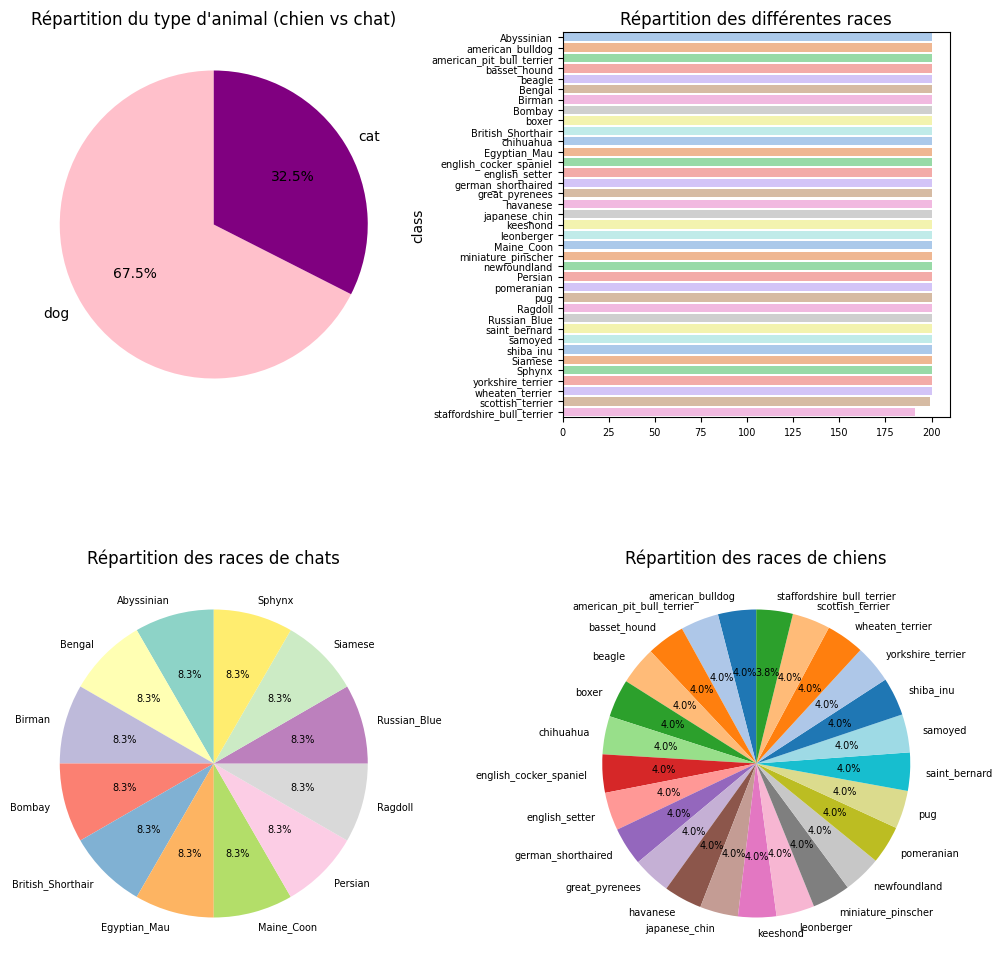

In [11]:
# Nombre d’images par type d'animal : chien vs chat
counts_1 = df["animal"].value_counts()

# Nombre d’images par race
counts_2 = df["class"].value_counts()

# Parmi les chats, répartition des races
counts_3 = df[df["animal"] == "cat"]["class"].value_counts()
counts_3 = counts_3[counts_3 > 0]
labels_cats =  [c for c in counts_3.index if counts_3[c] > 0]
palette_cat = sns.color_palette("Set3", n_colors=len(counts_3))

# Parmi les chiens, répartition des races
counts_4 = df[df["animal"] == "dog"]["class"].value_counts()
counts_4 = counts_4[counts_4 > 0]
labels_dogs =  [c for c in counts_4.index if counts_4[c] > 0]
palette_dog = sns.color_palette("tab20", n_colors=len(counts_4))

# Affichage des graphiques
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

axes[0,0].pie(counts_1, labels=counts_1.index, autopct='%1.1f%%', startangle=90, colors=["pink", "purple"])
axes[0,0].set_title("Répartition du type d'animal (chien vs chat)")

sns.barplot(x=counts_2.values, y=counts_2.index, palette="pastel", ax=axes[0,1])
axes[0,1].set_title("Répartition des différentes races")
axes[0,1].tick_params(axis='x', labelsize=7)
axes[0,1].tick_params(axis='y', labelsize=7) 

axes[1,0].pie(counts_3, labels=labels_cats, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_cat)
axes[1,0].set_title("Répartition des races de chats")

axes[1,1].pie(x=counts_4,  labels=counts_4.index, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7}, colors=palette_dog)
axes[1,1].set_title("Répartition des races de chiens")

plt.tight_layout
fig.subplots_adjust(hspace=0.4, wspace=0.4)  

plt.show()


Dans ce dataset, il y a beaucoup plus de chiens (67.5%) que de chats (32.5%). Malgré tout, les différentes races sont dans l'ensemble bien réparties puisqu'il y a 200 images pour chaque race, à l'exception de la race "staffordshire_bull_terrier", qui comporte un tout petit peu moins de 200 individus. Lorsque l'on regarde la répartion des 12 races de chats parmis les chats, elles sont parfaitement équilibrées. Il en va de même pour les chiens, à l'exception du "staffordshire_bull_terrier" qui représente 3.8% des races de chien (contre 4% pour les autres races).

### Vérification de la cohérence et la qualité des masques de segmentation

Un masque de segmentation est un masque de la même taille que l'image, qui va nous permettre d'avoir l'information du sujet de l'image. En effet, le masque va donner à chaque pixel de l'image une valeur parmi ces trois : 
- 1 si le pixel appartient au premier plan de l'image, soit l'animal dans notre cas 
- 2 si le pixel appartient à l'arrière-plan de l'image 
- 3 si le pixel n'est pas classifié.

Les masques de segmentation se trouvent dans le dossier *annotations/trimaps*. Nous allons donc regarder sur un petit jeu de données, sélectionné aléatoirement parmi notre dataset ce que donne le masque de segmentation. 


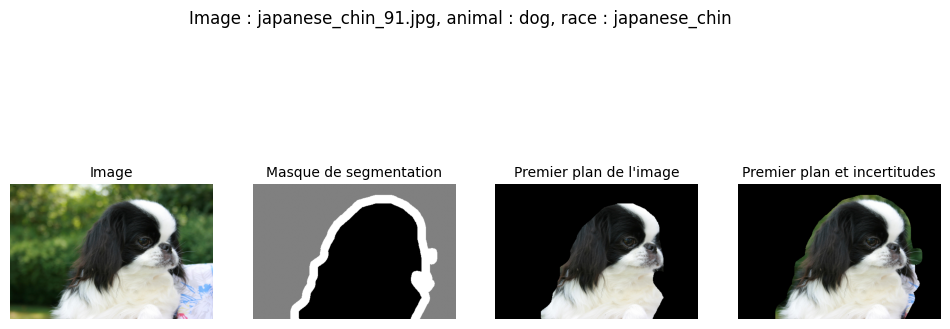

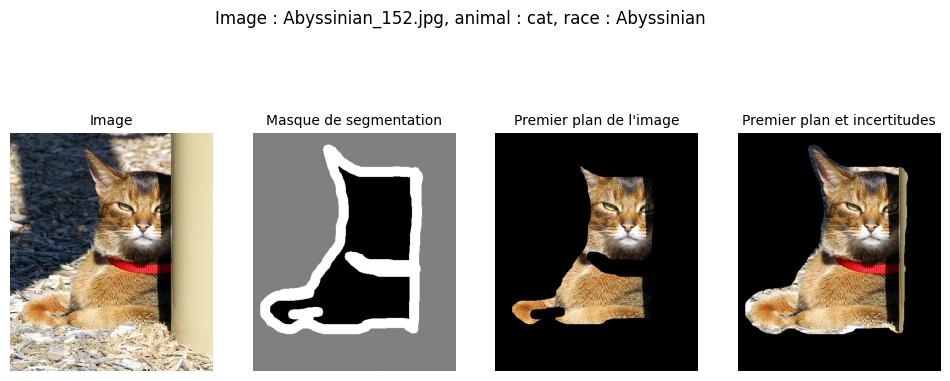

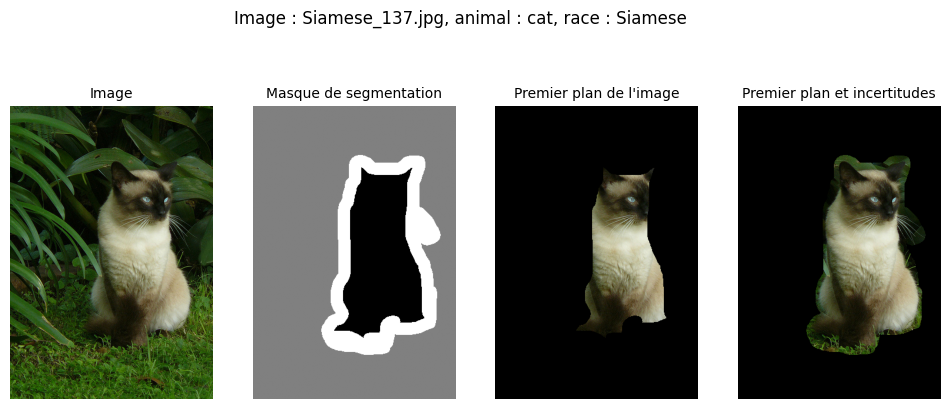

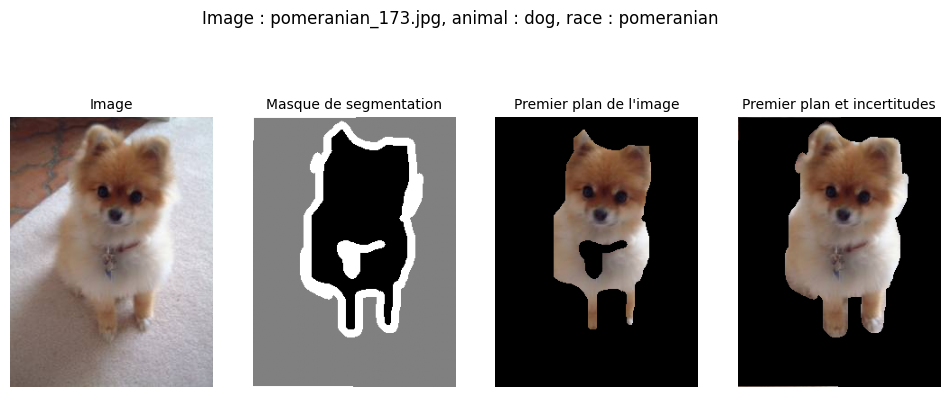

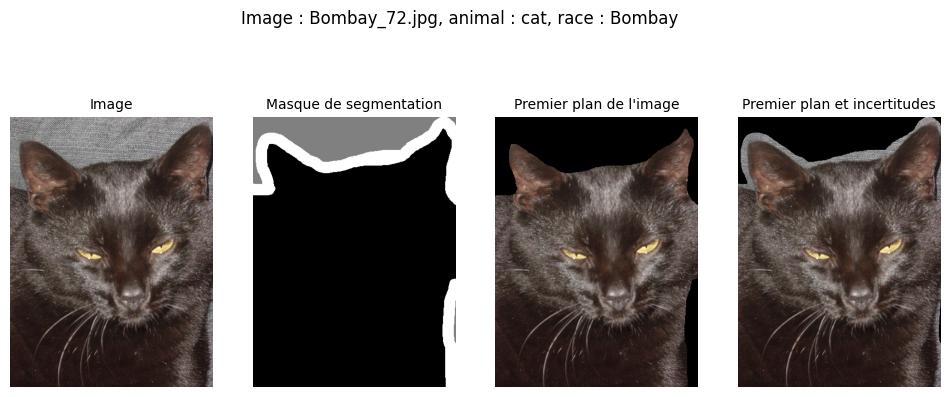

In [12]:
path_images = "./images/"
path_masks = "./annotations/trimaps/"

n = 5

for i in range(5): 
    # Sélection aléatoire d'une image
    filename = rd.choice(df['image'])

    # Chargement de l'image et du masque
    img = np.array(Image.open(path_images + filename))
    mask = np.array(Image.open(path_masks + filename.replace('.jpg', '.png')))

    # Image avec le masque appliqué (seulement le corps de l'animal)
    img_foreground = img.copy()
    img_foreground[mask != 1] = 0  

    # Image avec le masque appliqué (corps de l'animal + zone d'incertitude)
    img_background = img.copy()
    img_background[mask == 2] = 0

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))
    fig.suptitle(f"Image : {filename}, animal : {df[df['image'] == filename]['animal'].values[0]}, race : {df[df['image'] == filename]['class'].values[0]}")

    axes[0].imshow(img)
    axes[0].set_title("Image", fontsize=10)
    axes[0].axis("off")

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Masque de segmentation", fontsize=10)
    axes[1].axis("off")

    axes[2].imshow(img_foreground)  
    axes[2].set_title("Premier plan de l'image", fontsize=10)
    axes[2].axis("off")

    axes[3].imshow(img_background)
    axes[3].set_title("Premier plan et incertitudes", fontsize=10)
    axes[3].axis("off")

    plt.show()

Cela nous permet de vérifier que les masques sont cohérents avec l'image. Cependant, pour certaines photos, la zone d'incertitude peut être assez grande. C'est notamment le cas lorsque l'animal est de la même couleur que l'arrière plan, qu'il est caché par un objet, qu'il a des moustaches ou un collier. 

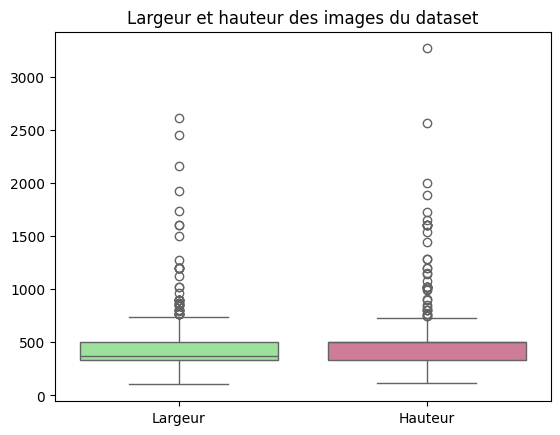

In [13]:
img_size = np.zeros((df.shape[0],2))
for i, filename in enumerate(df['image']) :
    img = img_to_array(load_img(path_images + filename) )
    img_size[i,:] = img.shape[:2]

plt.figure()
ax = sns.boxplot(img_size, palette = ['lightgreen', 'palevioletred'])
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['Largeur', 'Hauteur'])
plt.title("Largeur et hauteur des images du dataset")
plt.show()

On peut voir que les hauteurs et largeurs des images sont bien différentes. Pour la suite, on va les faire passer dans des réseeau de convolution. Il est donc intéressant d'avoir des images de même taille. 

## Classification binaire

Le premier objectif est de faire une classification binaire : à partir d'une photo, le but est de déterminer si elle montre un chat ou un chien.

### Pré - traitement des données

Dans un premier temps, nous séparons le jeu de données en un jeu de données pour l'entrainement, un pour la validation et un dernier qui sera utilisé pour tester le modèle à la fin.

In [ ]:
N_train = 5200 # taille du jeu d'entrainement
N_validation = 1400 # taille du jeu de validation

print("Pourcentage des données utilisées pour l'entrainement : ", N_train/len(df))
print("Pourcentage des données utilisées pour la validation : ", N_validation/len(df))
print("Pourcentage des données utilisées pour le test : ", (len(df) - N_train - N_validation)/len(df))

# Séparation des données en un jeu de données d'entrainement (80%) et un jeu de données de test (20%)
test_df, train_df = train_test_split(df, test_size=N_train)
test_df, validation_df = train_test_split(test_df, test_size=N_validation)

In [ ]:
# Vérification de la répartition des chiens et des chats dans les deux jeux de données
ratio_test = test_df['animal'].value_counts(normalize=True) * 100
ratio_train = train_df['animal'].value_counts(normalize=True) * 100
ratio_validation = validation_df['animal'].value_counts(normalize=True) * 100

print("Part de chien et chat dans les données d'entrainement")
print(ratio_train)
print("Part de chien et chat dans les données de test")
print(ratio_test)
print("Part de chien et chat dans les données de validation")
print(ratio_validation)

Les trois jeux de données (entraînement, test et validation) sont plutôt bien équilibrés : il y a quasiment la même proportion de chat et de chien dans les deux. Ces proportions se rapprochent également des 67.5% de chiens et 32.5% de chats présents dans le dataframe initial. 

Passons maintenant au redimensionnement des images. Il faut être vigilent à ce que la variable $\textit{batch\_size}$ soit un diviseur de $N_{\text{train}}$ et $N_{\text{test}}$, qui sont respectivement les tailles du jeu d'entraînement et de validation.

Remarque : il est primordial ici d'ajouter "shuffle=False" dans le test_generator car sinon pour la visualisation, on va prédire sur le générateur (donc un ordre désordonné du df) et les images plots vont (comparaison) sont sur le df de base donc forcement ca sera faux.


In [ ]:
img_width = 128
img_height = 128
batch_size = 20 # Diviseur de N_train et N_validation

# Images d'entrainement
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size,
    shuffle = False   # pour garder les bons indices : les images sont chargées dans l’ordre exact du dataframe
)

In [ ]:
labels = {0: 'Cat', 1: 'Dog'}

# Visualisation de quelques images d'entrainement, redimensionnées
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        plt.title(labels.get(y_batch[0]))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break
plt.tight_layout()
plt.show()

### Première approche : réseau de convolution simple

Une première approche pour notre problème est d'utiliser un réseau convolutif. Nous allons construire une version simplifiée de AlexNet. 


Les trois premiers blocs de ce réseau sont de la forme :
- Une couche de convolution, avec des filtres de taille $3 \times 3$ filtres et qui utilise la fonction d'activation $\texttt{Relu}$. Le premier a 32 filtres, le deuxième 64 et le dernier 96
- Une couche de MaxPooling, avec une fenêtre de $2 \times 2$

A la suite de ces trois blocs, on trouve :
- Une couche flatten, afin que les canaux puissent être lus par le réseau de neuronne 
- Une couche dense avec 64 neuronnes, qui utilise la fonction d'activation $\texttt{Relu}$ 
- Une couche dropout, qui met à 0 50% des sorties de la couche précédente. Cela permet une certaine régularisation
- Une couche dense avec un neuronne et une couche d'activation $\texttt{Sigmoid}$ 

In [ ]:
# Création du modèle 
 
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

In [ ]:
# Entraînement du modèle
cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Temps d'apprentissage pour %d epochs : %d secondes" % (epochs, t_learning_cnn_simple))

In [ ]:
# Fonctions utiles pour analyser les résultats

def prediction(model, train_generator, validation_generator):
    t_prediction = time.time()
    score_train = model.evaluate(train_generator, verbose=1)
    score_validation = model.evaluate(validation_generator, verbose=1)
    t_prediction = time.time() - t_prediction

    print('Train accuracy:', score_train[1])
    print('Validation accuracy:', score_validation[1])
    print("Time Prediction: %.2f seconds" % t_prediction)
    

def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, color='cadetblue', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, color='sandybrown', label='Validation accuracy')
    plt.title('Training et validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, color='cadetblue', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss, color='sandybrown', label='Validation loss')
    plt.title('Training et validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_history)

La précision obtenue est plutôt correcte : 82% pour les données de validation, et 95% pour les données d'entraînement. Cependant, on observe un surapprentissage clair : alors qu'à la moitié de l'apprentissage, les courbes de validation se stabilisent (cesse d'augmenter pour l'accuracy, de diminuer pour la loss), les courbes pour le training, elles, continuent d'évoluer. Une solution pour pallier ce problème est de faire de l'augmentation de data.

### CNN simple avec data augmentation

Afin d'éviter l'overfitting, une solution consiste à utilise l'augmentation de données. En effet, en transformant les images d'apprentissage (rotation, décalage...), on a un jeu de données bien plus grand, ce qui peut limiter le surapprentissage. On pourra ensuite suivre la même démarche que précédemment.

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'animal',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

In [ ]:
cnn_simple = Sequential()
cnn_simple.add(Input(shape=(img_width,img_height,3)))

cnn_simple.add(Conv2D(32, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(64, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Conv2D(96, (3,3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2,2)))

cnn_simple.add(Flatten())

cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

epochs = 10

cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_cnn_simple_augmented = time.time()

cnn_simple_augmented_history = cnn_simple.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)

t_learning_cnn_simple_augmented = time.time() - t_learning_cnn_simple_augmented

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple_augmented))

In [ ]:
prediction(cnn_simple, train_generator, validation_generator)
plot_training_analysis(cnn_simple_augmented_history)

On remarque que l'overfitting a diminué. En effet, les courbes suivent désormais la même trajectoire. De plus, les précisions obtenues pour les données d'apprentissage et de validation sont du même ordre de grandeur. Même si ces résultats sont corrects (75 à 80% de précision), ils peuvent être améliorés. Une solution consiste à utiliser le Transfer Learning.

### Transfer Learning avec augmentation de données

Le Transfer Learning consiste à utiliser un réseau déjà entraîné pour notre problème. Cela permet de mieux détecter les formes de l'image, et ainsi de mieux distinguer les chats et les chiens. On utilise ici VGG16, qui est composé de 5 blocs de convolution puis d'un MLP classique.Nous allons garder les poids du réseau de convolution, et construire notre propre MLP ensuite.

In [ ]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

In [ ]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

conv_base.trainable = False # On fige les poids de VGG

vgg_combined.summary()

In [ ]:
# Apprentissage 

epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

In [ ]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_history)

Les précision obtenues sont bien meilleures que précédemment (environ 90%). On peut essayer de les améliorer en faisant un apprentissage sur les poids du réseau VGG.  

Nous allons libérer les poids du dernier bloc de convolution de VGG pour qu'il soit libre pour l'apprentissage. On espère ainsi que VGG s'adaptera à notre problème et qu'on aura des meilleurs résultats que précédemment. 

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:15]:
    layer.trainable = False # On fige les poids des 4 premiers blocs de convolution de VGG

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

In [ ]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history)

Les résultats obtenus sont bien meilleurs que précédemment, jusqu'à atteindre 95% de précision. La fonction perte décroit elle aussi de manière significative par rapport à l'étape précédente. Essayons maintenant de faire un entraînement sur tous les poids du modèle. 

In [ ]:
conv_base.trainable = True # On libère tous les poids du modèle

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

In [ ]:
prediction(vgg_combined, train_generator, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

La précision obtenue avec ce dernier modèle monte jusqu'à 98%, ce qui est bien mieux. De même, la fonction perte a encore diminué de manière significative. Les fonctions de précision et de perte n'évoluant plus beaucoup, il est maintenant temps de tester ce modèle final.

### Test du modèle final

In [ ]:
test_prediction = vgg_combined.predict(test_generator)
score_test = vgg_combined.evaluate(test_generator)
print('Test accuracy:', score_test[1])

In [ ]:
fig = plt.figure(figsize=(10,10))

test_imgs_idx = np.random.randint(low=0, high=test_df.shape[0], size=(9,))

for i, idx in enumerate(test_imgs_idx):
    filename = test_df['image'].iloc[idx]
    img = img_to_array(load_img(path_images + filename) ) / 255
    pred = test_prediction[idx][0]
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img, interpolation='nearest')
    color = "seagreen"
    type = test_df['animal'].iloc[idx]
    
    if pred >0.5:
        title = "Probabilité pour un chien : %.1f" % (pred*100)
        if type == 'cat':
            color = "firebrick"
    else:
        title = "Probabilité pour un chat : %.1f" %((1-pred)*100)
        if type == 'dog':
            color = "firebrick"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()

En testant ce modèle sur le jeu de données de test, on obtient une précision de 96%, ce qui est tout à fait correct. En observant les images, on peut observer les erreurs du modèle.

## Classification fine

### Transfer Learning avec Vgg16

L'objectif ici est de réussir à identifier les différentes races parmi les 35 disponibles (pourquoi dans le sujets ils disent 
35). Une difficulté se présentera : la confusion de plusieurs races proches.

Je commence par prendre le même modèle que précédemment: modèle de transfer learning à partir de VGG16.

In [ ]:
conv_base = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

In [ ]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined_fine = Sequential()
vgg_combined_fine.add(Input(shape=(img_width, img_height, 3)))
vgg_combined_fine.add(conv_base)
vgg_combined_fine.add(Flatten())
vgg_combined_fine.add(Dense(256, activation='relu'))
vgg_combined_fine.add(Dense(35, activation='softmax')) #car 35 especes MODIF

conv_base.trainable = False # On fige les poids de VGG

vgg_combined_fine.summary()

In [ ]:
train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size=(img_width,img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de validation
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size
)

# Images de test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path_images,
    x_col = 'image',
    y_col = 'class',
    target_size = (img_width, img_height),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle=False
)

In [ ]:
# Apprentissage 

epochs = 5

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined_fine = time.time()
vgg_combined_history = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_fine = time.time() - t_learning_vgg_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_fine))

In [ ]:
prediction(vgg_combined_fine, train_generator_augmented, validation_generator)
plot_training_analysis(vgg_combined_history)

Les résultats obtenus ne sont pas très bons en terme d'accuracy. 
Cependant, on observe que l'accuracy est plus élevée dans le validation set que dans le training set ce qui semble étrange. Cela peut s'expliquer par le fait que l'augmentation de données a été faite seulement sur le training set et non sur le validation set donc le modèle s'entraine sur des images plus compliquées, bruitées et lorsqu'il revient sur des images plus simples il y arrive donc mieux.

Essayons en ne figeant plus les poids du modèle VGG16, c'est à dire que ceux-ci sont aussi modifiés et ajustés.

### Libération des poids de VGG16 : fine-tuning (les termes)

On implémente de nouveau le modèle en libérant cette fois ci seulement le block5 de VGG16 c'est à dire que seul le block5 pourra voir ses poids ajustés. On prend le dernier block car c'est celui qui capture les détails très spécifiques et donc celui qu'on veut ajuster pour le fine-tuning en gardant les poids des autres blocks qui apprennent les bords, les motifs simples et intermdiaires et les textures.

Donc un block = un ensemble cohérent de couches, pas une seule.

In [ ]:
conv_base_tuned = VGG16(
    weights = 'imagenet', # On garde les poids de l'entraînement sur le jeu de données ImageNet
    include_top = False,  # On ne garde pas la partie Dense
    input_shape = (img_width, img_height, 3)
)

conv_base_tuned.summary()

In [ ]:
# Création du réseau en ajoutant un MLP après le réseau de convolution VGG16
vgg_combined_fine = Sequential()
vgg_combined_fine.add(Input(shape=(img_width, img_height, 3)))
vgg_combined_fine.add(conv_base_tuned)
vgg_combined_fine.add(Flatten())
vgg_combined_fine.add(Dense(256, activation='relu'))
vgg_combined_fine.add(Dense(35, activation='softmax')) #car 35 especes

conv_base_tuned.trainable = True #  On libère tous les poids du modèle

# On dégèle que le block5
for layer in conv_base.layers:
    if not layer.name.startswith("block5"):
        layer.trainable = False


vgg_combined_fine.summary()

In [ ]:
# Apprentissage 
 
epochs = 5

vgg_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Learning rate plus faible pour ne pas écraser ce qui a été appris précédemment
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned2))

In [ ]:
prediction(vgg_combined_fine, train_generator_augmented, validation_generator)
plot_training_analysis(vgg_combined_tuned_history2)

On obtient de meilleurs résultats en libérant les poids de VGG16. De plus, la loss et l'accuracy pour la validation et training sets suivent la même tendance : il n'y a pas d'overfitting notable.

On remarque que figer les poids de VGG16 pour la classification binaire a donné des résultats très bons comparés aux nôtres. Cela s'explique par le fait que pour le cas "chat vs chien", les dernières couches du VGG16 contiennent déjà suffisamment d’informations pour séparer ces deux catégories. Or ici, avec 35 classes, nous avons besoin de features subtiles spécifiques à chaque race, que le modèle pré-entraîné sur ImageNet n'arrive pas à capturer : le MLP final n’a pas assez d’informations pour distinguer des différences fines.

Débloquer certaines couches de VGG16 permet d’adapter les filtres convolutionnels aux différences fines entre races.

## Data transfer learning 2 

Essayons d'obtenir de meilleurs résultats en faisant un transfer learning avec un modèle plus adapté: DenseNet. J'utilise le modèle DenseNet121 (121 couches au total) qui devrait être suffisant, en théorie pas besoin d'utiliser DenseNet169 ou DenseNet201 qui ont un plus grands nombres de couches.

DenseNet121 utilise des connexions denses : chaque couche reçoit les caractéristiques de toutes les couches précédentes. Cela permet de mieux capturer les détails fins, essentiels pour distinguer des classes très proches comme les races de chiens et chats.


In [ ]:
dense_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

dense_model.summary()

In [ ]:
dense_combined_fine = Sequential()
dense_combined_fine.add(Input(shape=(img_width, img_height, 3)))
dense_combined_fine.add(dense_model)
dense_combined_fine.add(Flatten())
dense_combined_fine.add(Dense(256, activation='relu'))
dense_combined_fine.add(Dropout(0.5)) 
dense_combined_fine.add(Dense(35, activation='softmax')) 

dense_model.trainable = False # On fige les poids de DenseNet

dense_combined_fine.summary()

In [ ]:
# Apprentissage 

epochs = 5

dense_combined_fine.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_dense_combined_fine = time.time()
dense_combined_history = dense_combined_fine.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_dense_combined_fine = time.time() - t_learning_dense_combined_fine

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_dense_combined_fine))

In [ ]:
prediction(dense_combined_fine, train_generator_augmented, validation_generator)
plot_training_analysis(dense_combined_history)

Ces résultats sont bien plus satisfaisants en terme d'accuracy. Le modèle utilisé est bein plus intéressant que VGG16.On observe encore une fois que l'accuracy du validation set est plus élevé que dans le training set. D'après les graphes, on a pas de problèmes d'over fitting car le modèle est moins bien pour le training.

Cependant, le modèle ici est beaucoup plus complexe et profind que celui avec vgg16 et l'accuracy n'a pas enormement augmentée, on peut se posr la question de est ce que ca vaut vraiemnt le coup en terme de couts et d eresulats obtenus.


### Test

Je teste sur le meilleur modèle: dense_combined_fine

In [ ]:
test_prediction = dense_combined_fine.predict(test_generator)
score_test = dense_combined_fine.evaluate(test_generator)
print('Test accuracy:', score_test[1])

In [ ]:
class_names = {v: k for k, v in test_generator.class_indices.items()}

x_batch, y_batch = next(test_generator)
# récupérer toutes les images et labels dans l'ordre exact
X_test, y_test = [], []
for i in range(len(test_generator)):
    x, y = test_generator[i] 
    # x_batch=Contient toutes les images du test set dans l’ordre exact du generator , x_batch.shape = (batch_size, img_width, img_height, 3)
    #y_test.shape = (nb_images, nb_classes), Contient tous les labels one-hot correspondants
    X_test.append(x)  
    y_test.append(y)
X_test = np.vstack(X_test)   #X_test[i] = image envoyée au modèle pour prédiction n°i
y_test = np.vstack(y_test)  #y_test[i] = label exact correspondant à X_test[i]
test_prediction = vgg_combined_fine.predict(X_test)

fig = plt.figure(figsize=(10,10))
indices = np.random.choice(len(X_test), 9, replace=False)

for i, idx in enumerate(indices):
    img = X_test[idx]
    pred = test_prediction[idx]
    #On utilise maintenant le label provenant directement du generator, pas du dataframe original
    pred_class_idx = np.argmax(pred)
    pred_class_prob = np.max(pred)
    true_class_idx = np.argmax(y_test[idx])
    
    ax = fig.add_subplot(3,3,i+1)
    ax.imshow(img)
    
    color = "seagreen" if pred_class_idx == true_class_idx else "firebrick"
    title = f"{class_names[pred_class_idx]} : {pred_class_prob*100:.1f}%"
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()


### Etude de la confusion

In [ ]:
del list

# classes réelles et prédictions
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

# afficher la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(class_names.values()))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax, cmap='Blues', colorbar=True, values_format='d')
plt.xticks(rotation=90)
plt.title("Matrice de confusion (non normalisée)")
plt.show()

#### Pour Abyssinian vs Bengal

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

aby_df = test_df[test_df['class'] == "Abyssinian"]
filename = aby_df['image'].iloc[4]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Abyssinian") 

bengal_df = test_df[test_df['class'] == "Bengal"]
filename2 = bengal_df['image'].iloc[3]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image Bengal") 
plt.show(

In [ ]:
class_to_idx = {v: k for k, v in class_names.items()}  # On inverse pour obtenir {classe: index}
classes_proches = ['Abyssinian', 'Bengal']
idx_proches = [class_to_idx[c] for c in classes_proches] # On garde en mémoire leurs indices

# y_true et y_pred pour tout le test set
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)

# Filtrer uniquement les images de ces classes
mask = np.isin(y_true, idx_proches)  #retourne un tableau de booléens tq si l'image est aby ou bengal ca retourne True sinon False : sert juste à sélectionner les images dont la vraie classe est l’une des deux races que tu veux analyser
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion Abyssinian vs Bengal")
plt.show()

On voit que le modèle prédit globalement bien ces deux races, on observe une confusion lorsque le chat est un bengal. Ce sont des résultats raisonables compte tenue du modèle.


#### Pour Boxer vs American A MODIFEIR

Regardons à quoi ressemble les deux races.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

boxer_df = test_df[test_df['class'] == "boxer"]
filename = boxer_df['image'].iloc[4]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Boxer") 

american_df = test_df[test_df['class'] == "american"]
filename2 = american_df['image'].iloc[3]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image American") 
plt.show()

In [ ]:
class_to_idx = {v: k for k, v in class_names.items()}
classes_proches = ['boxer', 'american']
idx_proches = [class_to_idx[c] for c in classes_proches]

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion boxer vs american")
plt.show()

Pour cette race qui se ressemble assez, les résultats sont encore une fois pas mauvais, une légère confusion est remarquée lorsque l'image représente un boxer.

#### Pour Beagle vs American

Regardons la matrice de confusion des deux races.

In [ ]:
class_to_idx = {v: k for k, v in class_names.items()}
classes_proches = ['beagle', 'american']
idx_proches = [class_to_idx[c] for c in classes_proches]

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(test_prediction, axis=1)
mask = np.isin(y_true, idx_proches)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]


cm_subset = confusion_matrix(y_true_filtered, y_pred_filtered, labels=idx_proches)

# Affichage
disp = ConfusionMatrixDisplay(cm_subset, display_labels=classes_proches)
disp.plot(cmap='Reds', values_format='d')
plt.title("Confusion beagle vs american")
plt.show()

Ici on remarque que le modèle fait un peu plus d'erreur pour ces deux races: il prédit un americain lorsque le chien est un beagle. Il arrive bien à prédire l'american mais pas le beagle. Regardons à quoi ressemble ces chiens.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 ligne, 2 colonnes

beagle_df = test_df[test_df['class'] == "beagle"]
filename = beagle_df['image'].iloc[3]
img1 = img_to_array(load_img(path_images + filename) ) / 255

axes[0].imshow(img1)
axes[0].set_title("Image Beagle") 

american_df = test_df[test_df['class'] == "american"]
filename2 = american_df['image'].iloc[4]
img2 = img_to_array(load_img(path_images + filename2) ) / 255

axes[1].imshow(img2)
axes[1].set_title("Image American") 
plt.show()

Les chiens se ressemblent légèrement, beaucoup moins que le boxer et l'american.

In [ ]:
print(beagle_df.shape) 
print(american_df.shape) 

On a au total 21 images de beagles et 51 d'american ce qui pourait expliquer pourquoi le modèle tend à prédire "american" plutot que "beagel": il a plus vu d'americane que de beagle et est donc moins " fort" pour cette race.


## Segmentation des animaux 

### Implémentation du réseau de type U-Net

Dans cette partie, nous allons nous intéresser à la segmentation des chiens et des chats grâce à un réseau U-Net: cela signifie que nous allons attribuer une "étiquette" à chaque pixel de notre image. On commence donc par préparer les images pour notre segmentation.

I0000 00:00:1764755047.037232    6330 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13922 MB memory:  -> device: 0, name: NVIDIA RTX 2000 Ada Generation, pci bus id: 0000:55:00.0, compute capability: 8.9


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 192)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    110,656 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]  

 Total params: 487,297 (1.86 MB)

 Trainable params: 487,297 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2025-12-03 10:44:15.075441: I external/local_xla/xla/service/service.cc:163] XLA service 0x76146c003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-03 10:44:15.075467: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX 2000 Ada Generation, Compute Capability 8.9
2025-12-03 10:44:15.562661: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-03 10:44:16.895725: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301


  1/258 ━━━━━━━━━━━━━━━━━━━━ 1:29:54 21s/step - accuracy: 0.6180 - loss: 0.6923

I0000 00:00:1764755073.695652    7246 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 ━━━━━━━━━━━━━━━━━━━━ 97s 298ms/step - accuracy: 0.7197 - loss: 0.5269 - val_accuracy: 0.7763 - val_loss: 0.4649
Epoch 2/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 34s 114ms/step - accuracy: 0.7937 - loss: 0.4350 - val_accuracy: 0.8085 - val_loss: 0.4110
Epoch 3/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.8172 - loss: 0.3961 - val_accuracy: 0.8293 - val_loss: 0.3795
Epoch 4/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 113ms/step - accuracy: 0.8369 - loss: 0.3630 - val_accuracy: 0.8491 - val_loss: 0.3455
Epoch 5/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 106ms/step - accuracy: 0.8492 - loss: 0.3395 - val_accuracy: 0.8621 - val_loss: 0.3208
Epoch 6/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.8577 - loss: 0.3228 - val_accuracy: 0.8676 - val_loss: 0.3096
Epoch 7/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8642 - loss: 0.3094 - val_accuracy: 0.8703 - val_loss: 0.3047
Epoch 8/10
258/258 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8693 - loss: 0.2989 - val_a

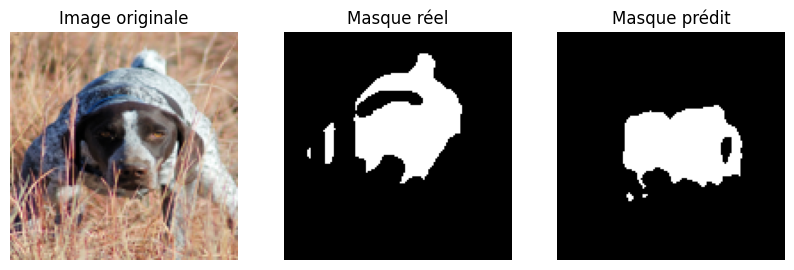

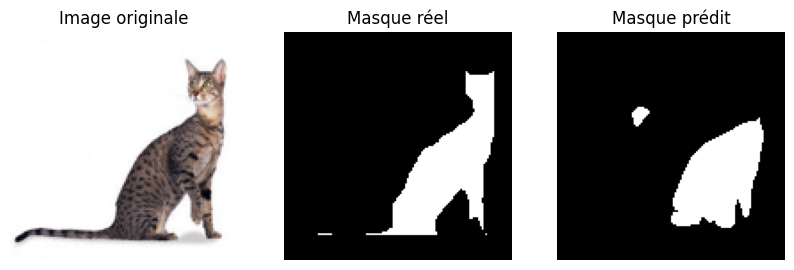

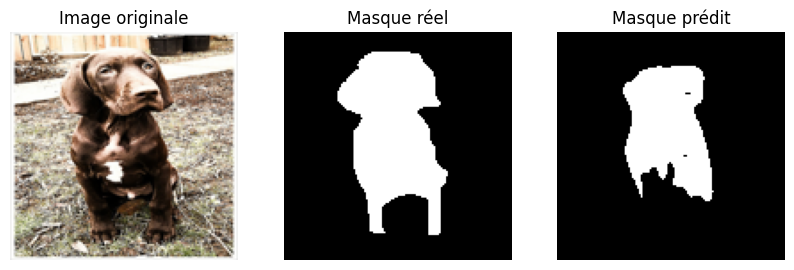

IoU: 0.48842874
Dice: 0.65630114


In [14]:
# SEGMENTATION D'ANIMAUX AVEC U-NET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# PARAMÈTRES GÉNÉRAUX

img_width = img_height = 128   # Test de taille uniforme mais pas convaincue par la taille, voir si amélioration possible
batch_size = 20

path_images = "./images/"
path_masks  = "./annotations/trimaps/"


# Split train / val / test
train_df = df.sample(frac=0.7, random_state=42)
temp_df  = df.drop(train_df.index)
validation_df = temp_df.sample(frac=0.5, random_state=42)
test_df = temp_df.drop(validation_df.index)

# GÉNÉRATEURS IMAGES + MASQUES

def image_generator(df, path_images, batch_size=8):
    while True:
        # Shuffle à chaque epoch pour éviter que le modèle s'habitue à l'ordre des images
        df_shuffled = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            imgs = []
            for fname in batch_df['image']:
                img = np.array(
                    Image.open(path_images + fname)
                    .resize((img_width,img_height))
                    .convert("RGB")          # ⚠️ garantit 3 canaux
                )
                img = img / 255.0
                imgs.append(img)
            yield np.array(imgs, dtype=np.float32)


def mask_generator(df, path_masks, batch_size=8):
    while True:
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            masks = []
            for fname in batch_df['image']:
                mask = np.array(
                    Image.open(path_masks + fname.replace('.jpg','.png'))
                    .resize((img_width,img_height))
                    .convert("L")            # ⚠️ niveaux de gris = 1 canal
                )
                # Binarisation : 1 = animal, 0 = fond
                mask_binary = np.where(mask == 1, 1, 0)[..., np.newaxis]
                masks.append(mask_binary)
            yield np.array(masks, dtype=np.float32)


# Fusionner les deux générateurs pour créer (image, masque)
def combined_generator(df, path_images, path_masks, batch_size=8):
    img_gen = image_generator(df, path_images, batch_size)
    mask_gen = mask_generator(df, path_masks, batch_size)
    while True:
        imgs = next(img_gen)
        masks = next(mask_gen)
        yield imgs, masks


# Train et Validation generators
train_generator      = combined_generator(train_df, path_images, path_masks, batch_size)
validation_generator = combined_generator(validation_df, path_images, path_masks, batch_size)
test_generator       = combined_generator(test_df, path_images, path_masks, batch_size)


# MODÈLE U-NET

def unet(input_size=(img_width, img_height, 3)):
    inputs = Input(input_size)

    # --- Encodeur ---
    c1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    # --- Bottleneck ---
    c4 = Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)

    # --- Decodeur ---
    u5 = UpSampling2D()(c4)
    u5 = Concatenate()([u5, c3])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = Concatenate()([u6, c2])
    c6 = Conv2D(32, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(32, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = Concatenate()([u7, c1])
    c7 = Conv2D(16, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs, outputs)
    return model


model = unet()
model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])
model.summary()

# ENTRAÎNEMENT

steps_per_epoch = len(train_df) // batch_size
validation_steps = len(validation_df) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    epochs=10
)

# MÉTRIQUES DE SEGMENTATION

def iou(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.round(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2 * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


# VISUALISATION DE RÉSULTATS

imgs, masks = next(train_generator)
preds = model.predict(imgs[:3])

for i in range(3):
    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(imgs[i])
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(masks[i,:,:,0], cmap="gray")
    plt.title("Masque réel")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(preds[i,:,:,0] > 0.5, cmap="gray")
    plt.title("Masque prédit")
    plt.axis("off")

    plt.show()

print("IoU:", iou(masks[:1], preds[:1]).numpy())
print("Dice:", dice_coef(masks[:1], preds[:1]).numpy())


Le Dice mesure le degré de similarité entre la prédiction et la vérité.
Il compare combien de pixels sont communs par rapport à la taille totale des deux zones combinées.

L’IoU mesure à quel point la zone prédite par un modèle correspond réellement à la zone vraie (ground truth).

Il compare :

Intersection : la partie commune entre la prédiction et la vérité.

Union : l’ensemble des zones couvertes par la prédiction ou la vérité.

## Analyse Comparative

Dans cette partie, on s'interesse au comportement du modèle U-net en fonction de la race. On cherche donc notemment à répondre aux questions suivantes : 
- Est-ce que certaines races sont mieux segmentées que d'autres ? 
- Est ce qu'il est plus facile de segmenter un chien ou un chat ? 

Idée : Nous vennons d'entraîner un modèle de type U-net sur nos données. L'objectif et de déterminer si ce dernier présente des biais dans sa reconnaissance et sa segmentation des animaux.
On va donc considérer toutes les images de la base de donnée de test, les passer dans le modèle et récupérer les scores IoU et DICE pour les analyser. 

In [17]:
# Tableau récapitulatif des performanes par images

liste_results = []

for i in range(len(test_df)):
    #Récupération des informations associées à l'image courante
    filename    = test_df['image'].iloc[i]
    race        = test_df['class'].iloc[i]     # nom de la race
    animal_type = test_df['animal'].iloc[i]      # "cat" ou "dog"

    # Chargement de l'image
    img = np.array(
        Image.open(os.path.join(path_images, filename))
        .resize((img_width, img_height))
        .convert("RGB")
    ) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W, 3)

    # Chargement du masque réel associé
    mask = np.array(
        Image.open(os.path.join(path_masks, filename.replace('.jpg', '.png')))
        .resize((img_width, img_height), resample=Image.NEAREST)
        .convert("L")
    )
    # Binarisation du masque : on prépare le masque à être de la même forme que la sortie pour pouvoir comparer
    # 1 = animal, 2 = fond, 3 = non classifié  --> binaire : animal = 1, le reste = 0
    mask_binary = np.where(mask == 1, 1.0, 0.0)[..., np.newaxis].astype(np.float32)  # (H, W, 1)
    mask_binary = np.expand_dims(mask_binary, axis=0)  # (1, H, W, 1)


    # Prédiction de la segmentation en appelant le modèle Unet entraîné précedement
    pred = model.predict(img, verbose = 0)  # (1, H, W, 1)

    # Calcul des scores
    iou_score  = float(iou(mask_binary, pred).numpy())
    dice_score = float(dice_coef(mask_binary, pred).numpy())

    # Stockage des information
    liste_results.append({
        "image": filename,
        "race": race,             
        "animal": animal_type,
        "iou": iou_score,
        "dice": dice_score
    })
# Conversion en dataframe pour les manipulations
results_df = pd.DataFrame(liste_results)

# Première visualisation
results_df.head()


,image,race,animal,iou,dice
0,Abyssinian_101.jpg,Abyssinian,cat,0.281167,0.438923
1,Abyssinian_102.jpg,Abyssinian,cat,0.432540,0.603878
2,Abyssinian_104.jpg,Abyssinian,cat,0.737424,0.848871
3,Abyssinian_105.jpg,Abyssinian,cat,0.143341,0.250741
4,Abyssinian_109.jpg,Abyssinian,cat,0.360603,0.530063


### Analyse comparative par race

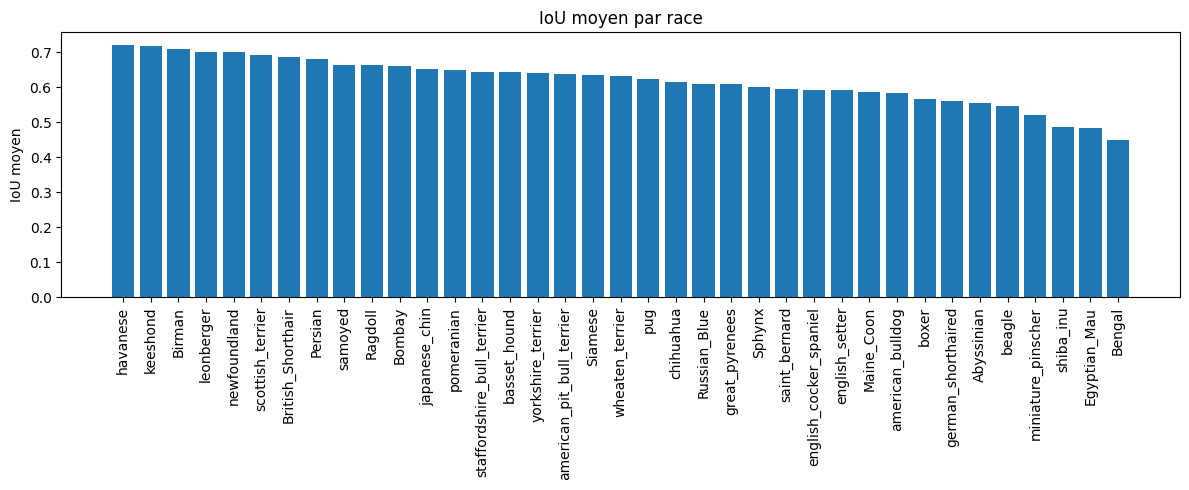

In [19]:
# Est ce que certaines races sont plus difficiles à segmenter que d'autres ?

# 1) Calcul de statistique sur les IoU par race
stats_race = results_df.groupby("race").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

# 2) Trier pour voir les meilleures/pire races
# Comme les effectifs sont proches les moyennes sont peu influencées
stats_race_trie = stats_race.sort_values(by="mean_iou", ascending=False)

# 3) Visualisation : barplot des IoU moyens par race
plt.figure(figsize=(12, 5))
plt.bar(stats_race_trie["race"], stats_race_trie["mean_iou"])
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("IoU moyen par race")
plt.tight_layout()
plt.show()


In [ ]:
On constate que les Bengal semble en moyenne moins bien segmentés. 

In [ ]:
# Focus sur les 5 meilleures et les 5 pires races
top10  = stats_race_trie.head(5)
worst10 = stats_race_trie.tail(5)
plt.figure(figsize=(12, 5))
plt.bar(top10["race"], top10["mean_iou"], color='seagreen', label='Top 5')
plt.bar(worst10["race"], worst10["mean_iou"], color='salmon', label='Worst 5')
plt.xticks(rotation=90)
plt.ylabel("IoU moyen")
plt.title("Top 5 et Worst 5 des races par IoU moyen")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Analyse comparative par type d'animal : Chat vs Chien
#Est ce qu'il est plus facile de segmenter les chats ou les chiens ?
# Statistiques par type d'animal
stats_type = results_df.groupby("type").agg(
    mean_iou   = ("iou", "mean"),
    median_iou = ("iou", "median"),
    std_iou    = ("iou", "std"),
    mean_dice  = ("dice", "mean"),
    count      = ("iou", "count")
).reset_index()

print(stats_type)   

# Visualisation : barplot des IoU moyens par type d'animal
plt.figure(figsize=(6, 5))
plt.bar(stats_type["type"], stats_type["mean_iou"], color=['pink', 'lightblue'])
#plt.bar(stats_type["type"], stats_type["mean_iou"], color=["#ffb6c1", "#add8e6"])
plt.ylabel("IoU moyen")
plt.title("IoU moyen par type d'animal")
plt.tight_layout()
plt.show()  

# Visualisation : boxplot des IoU par type d'animal
plt.figure(figsize=(6, 5))
sns.boxplot(x="type", y="iou", data=results_df, palette=['pink', 'lightblue'])
plt.ylabel("IoU")
plt.title("Distribution des IoU par type d'animal")
plt.tight_layout()
plt.show() 


On cherche à comparer les moyennes de deux distributions :
ici : IoU des chats vs IoU des chiens
hypothèse nulle H0 : les deux groupes ont la même moyenne
hypothèse alternative H1 : les moyennes sont différentes

In [ ]:
# Histogrammes des IoU pour les chats et les chiens
#Pour vérifier si c'est gaussien ou pas
iou_chats = resultats_df[results_df["type"] == "cat"]["iou"]
iou_chiens = resultats_df[resultats_df["type"] == "dog"]["iou"]


plt.figure(figsize=(12, 5))
sns.histplot(iou_chats, kde=True, color="pink")
plt.title("Distribution IoU - Chats")
plt.show()

sns.histplot(iou_chiens, kde=True, color="lightblue")
plt.title("Distribution IoU - Chiens")
plt.show()


Dans la segmentation :
les IoU sont souvent pas du tout gaussiens
distribution souvent asymétrique (beaucoup de bons IoU + quelques mauvais)

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

#QQ-plot des IoU pour les chats et les chiens

stats.probplot(iou_chats, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chats")
plt.show()

stats.probplot(iou_chiens, dist="norm", plot=plt)
plt.title("QQ-plot IoU - Chiens")
plt.show()


In [ ]:
#Test de normalité de Shapiro-Wilk
#Attention : avec beaucoup de données, Shapiro rejette souvent à tort.

stat, p = shapiro(iou_chats)
print("Shapiro Chats:", p)

stat, p = shapiro(iou_chiens)
print("Shapiro Chiens:", p)


In [ ]:
#Si gaussien on peut faire un t-test, sinon un test de mann-whitney

# T-test
stat, p_value = ttest_ind(iou_chats, iou_chiens)
print("T-test entre IoU des chats et des chiens : stat=%.3f, p=%.3f" % (stat, p_value))
if p_value < 0.05:
    print("Différence significative entre les IoU des chats et des chiens (p < 0.05)")
else:
    print("Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)")#!/usr/bin/env python3

# Mann-Whitney U test
stat, p_value = mannwhitneyu(iou_chats, iou_chiens)
print("Mann-Whitney U test entre IoU des chats et des chiens : stat=%.3f, p=%.3f" % (stat, p_value))
if p_value < 0.05:
    print("Différence significative entre les IoU des chats et des chiens (p < 0.05)")
else:
    print("Pas de différence significative entre les IoU des chats et des chiens (p >= 0.05)")
